# Invalid Sample Detection

In [1]:
from scipy import signal

import matplotlib.pyplot as plt
import numpy             as np
import wfdb
import scipy.fftpack
import scipy
import math

%matplotlib inline
%config IPCompleter.greedy=True

We check that the signal is valid by examining the signal amplitude in an invalid frequency range, looking at various statistical properties, etc. 

## Invalid frequency signal amplitude

### Filter analysis

We make a bandpass filter on the range 70-90 Hz and check the signal amplitude in this range. If the signal amplitude exceeds limits, the data is marked as invalid.

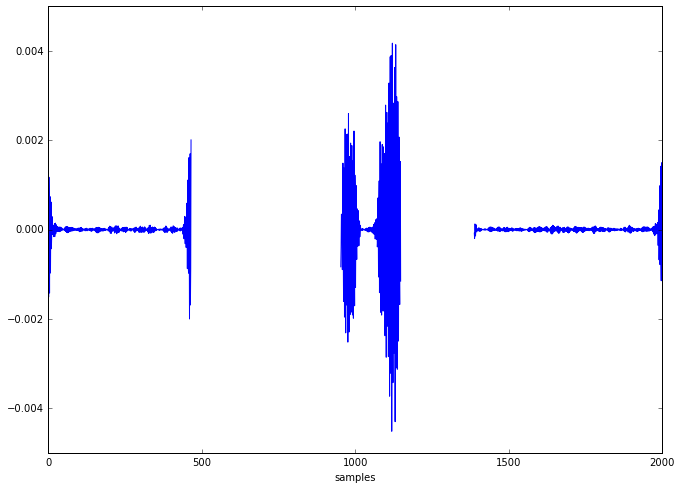

In [26]:
order = 50
f_low = 70
f_high = 90

def band_pass_filter(signal, f_low, f_high, order): 
    window = scipy.signal.firwin(order+1, [f_low, f_high], nyq=np.floor(fs/2), pass_zero=False,
                  window='hamming', scale=False)

    if len(signal) < 153: 
        return
    return scipy.signal.filtfilt(window, 1, signal)

sig, fields=wfdb.rdsamp('sample_data/challenge_training_data/a170s')
fs = 250
start = 292
end = 300
duration = end - start

a170s_signal = sig[start*fs:end*fs,:]
filtered_a170s_signal = band_pass_filter(a170s_signal[:,1], f_low, f_high, order)
    
# plot the data 
plt.figure(figsize=[11,8])
# plt.plot(a170s_signal[:,1],'r-')
plt.plot(filtered_a170s_signal,'b-')
plt.xlabel('samples')
plt.show()

In [28]:
cutoff = 0.005

def is_amplitude_within_cutoff(signal, f_low, f_high, cutoff):  
    filtered_signal = band_pass_filter(signal, f_low, f_high, order)
    if filtered_signal is not None: 
        for signal_amplitude in filtered_signal: 
            if signal_amplitude > cutoff: 
                return False
    return True

print is_amplitude_within_cutoff(a170s_signal[:,1], f_low, f_high, cutoff)

True


## Statistical analysis

In [7]:
def check_stats_within_cutoff(signal, channel_type, stats_cutoffs): 
    signal_min = min(signal)
    signal_max = max(signal)
    var_range = signal_max - signal_min
    channel_stats_cutoffs = stats_cutoffs[channel_type]
    
    if signal_min < channel_stats_cutoffs["val_min"] or signal_max > channel_stats_cutoffs["val_max"]: 
        return False
    
    if var_range > channel_stats_cutoffs["var_range_max"] or var_range < channel_stats_cutoffs["var_range_min"]: 
        return False
    
    return True

## Other metrics

In [8]:
def contains_nan(signal): 
    for element in signal: 
        if math.isnan(element): 
            return True
    return False

## Putting it all together

In [29]:
def get_channel_type(channel_name): 
    if channel_name == "ABP" or channel_name == "PLETH" or channel_name == "RESP": 
        return channel_name
    return "ECG"

In [30]:
def is_valid(signal, channel_type, f_low, f_high, freq_amplitude_cutoff, stats_cutoffs): 
    nan_check = !contains_nan(signal) 
    stats_check = check_stats_within_cutoff(signal, channel_type, stats_cutoffs)
    
    if channel_type == "ECG": 
        signal_amplitude_check = is_amplitude_within_cutoff(signal, f_low, f_high, freq_amplitude_cutoff)
        return signal_amplitude_check and nan_check and stats_check
    return nan_check and stats_check
    
def calculate_invalids(sig, channels, window_start, window_end, f_low, f_high, amplitude_cutoff, stats_cutoffs): 
    invalids = {}
    
    for channel in channels: 
        invalids[channel] = []
    
    for channel_num in range(len(channels)): 
        start = window_start
        channel_name = channels[channel_num]
        channel_type = get_channel_type(channel_name)
        
        while start * fs < window_end: 
            signal = sig[int(start*fs):int((start + block_length)*fs),:]
            channel_signal = signal[:,channel_num]
            start += block_length

            is_data_valid = is_valid(channel_signal, channel_type, f_low, f_high, amplitude_cutoff, stats_cutoffs)
            if is_data_valid: 
                invalids[channel_name].append(0)             
            else: 
                invalids[channel_name].append(1)
    
    return invalids
                
def calculate_cval(invalids): 
    cvals = {}
    for channel_name in invalids.keys(): 
        channel_invalids = invalids[channel_name]
        if len(channel_invalids) > 0: 
            cvals[channel_name] = 1 - float(sum(channel_invalids)) / len(channel_invalids)
        else: 
            cvals[channel_name] = None
    return cvals

In [31]:
if __name__ == '__main__': 
    sample = 'sample_data/challenge_training_data/a170s'
    fs = 250
    block_length = 0.8
    
    sig, fields = wfdb.rdsamp(sample)
    channels = fields['signame']
    start = 0
    end = len(sig)
    
    order = 50
    f_low = 70
    f_high = 90
    amplitude_cutoff = 0.005
    stats_cutoffs = {
        "ECG" : {
            "val_min" : -7,
            "val_max" : 7, 
            "var_range_min" : 0.005,
            "var_range_max" : 8
        }, 
        "ABP" : {
            "val_min" : 0,
            "val_max" : 300, 
            "var_range_min" : 0.0001,
            "var_range_max" : 250
        }, 
        "PLETH" : {
            "val_min" : -6,
            "val_max" : 6, 
            "var_range_min" : 0.005,
            "var_range_max" : 7
        }
    }
    
    invalids = calculate_invalids(sig, channels, start, end, f_low, f_high, amplitude_cutoff, stats_cutoffs)    

    print calculate_cval(invalids)

{'II': 0.944, 'PLETH': 0.8186666666666667, 'ABP': 1.0, 'V': 0.8346666666666667}


## Appendix: not super relevant but nice to keep

### FFT analysis

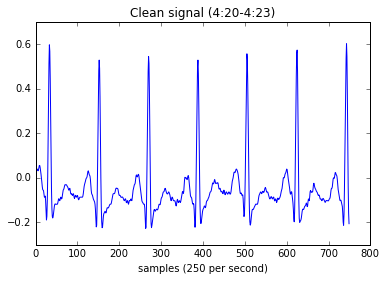

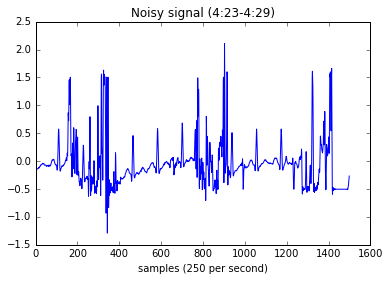

In [12]:
# There is a noisy section of this signal - between 4:20 and 4:25 (260 and 265 seconds)
sig, fields=wfdb.rdsamp('sampledata/a103l')
fs = 250
clean_start = 260
clean_end = 263
clean_duration = clean_end - clean_start

noisy_start = 263
noisy_end = 269
noisy_duration = noisy_end - noisy_start

clean_signal = sig[clean_start*fs:clean_end*fs,:]
noisy_signal = sig[noisy_start*fs:noisy_end*fs,:]

plt.plot(clean_signal[:,0],'b-')
plt.title('Clean signal (4:20-4:23)')
plt.xlabel('samples (250 per second)')
plt.show()

plt.title('Noisy signal (4:23-4:29)')
plt.plot(noisy_signal[:,0],'b-')
plt.xlabel('samples (250 per second)')
plt.show()

To check if the signal amplitude in the range 70-90 Hz is outsize the limits (> 0.005 mV), we look at the fft of the signal:  

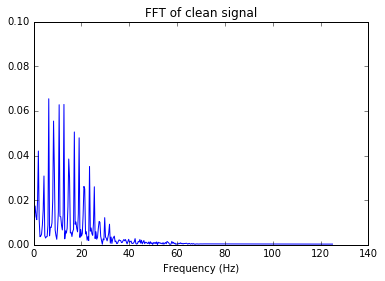

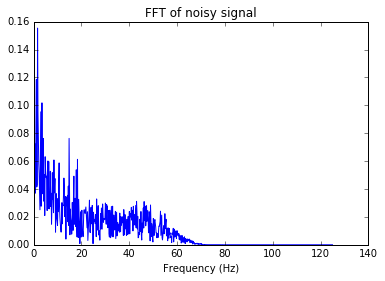

In [13]:
def get_signal_fft(signal, signal_duration, channel): 
    # Number of samplepoints
    N = signal_duration * fs
    # sample spacing
    T = 1.0 / fs
    
    xf = np.linspace(0.0, 1.0/(2.0*T), N/2)
    signal_fft = scipy.fftpack.fft(signal[:,channel])
    
    return (xf, 2.0/N * np.abs(signal_fft[:N/2]))
    
def plot_signal_fft(signal_xf, signal_fft, title=""):
    fig, ax = plt.subplots()
    ax.plot(signal_xf, signal_fft)
    plt.title(title)
    plt.xlabel("Frequency (Hz)")
    plt.show()

clean_xf, clean_signal_fft = get_signal_fft(clean_signal, clean_duration, 0)
noisy_xf, noisy_signal_fft = get_signal_fft(noisy_signal, noisy_duration, 0)
plot_signal_fft(clean_xf, clean_signal_fft, "FFT of clean signal")
plot_signal_fft(noisy_xf, noisy_signal_fft, "FFT of noisy signal")

In [4]:
noisy_amplitude_limit = 0.005

def get_fft_amplitude(signal_fft, frequency, signal_duration): 
    return signal_fft[frequency * signal_duration]

def check_frequency_amplitude_limits(signal_fft, signal_duration): 
    for frequency in range(70, 91): 
        if get_fft_amplitude(signal_fft, frequency, signal_duration) > noisy_amplitude_limit: 
            return "Invalid data"
    return "Valid data"
    
print check_frequency_amplitude_limits(clean_signal_fft, clean_duration)
print check_frequency_amplitude_limits(noisy_signal_fft, noisy_duration)

Valid data
Valid data


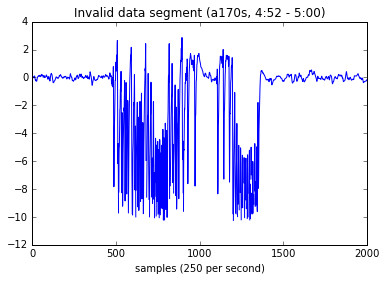

TypeError: get_signal_fft() takes exactly 3 arguments (2 given)

In [14]:
sig, fields=wfdb.rdsamp('sample_data/challenge_training_data/a170s')
fs = 250
start = 292
end = 300
duration = end - start

a170s_signal = sig[start*fs:end*fs,:]

plt.plot(a170s_signal[:,1],'b-')
plt.title('Invalid data segment (a170s, 4:52 - 5:00)')
plt.xlabel('samples (250 per second)')
plt.show()

xf, signal_fft = get_signal_fft(a170s_signal, duration)
plot_signal_fft(xf, signal_fft)
print check_frequency_amplitude_limits(signal_fft, duration)

Putting this all together to visualize the raw signal, the filtered signal, and the FFT of the signal: 

['II', 'V', 'PLETH', 'ABP']


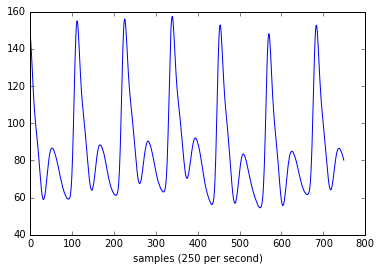

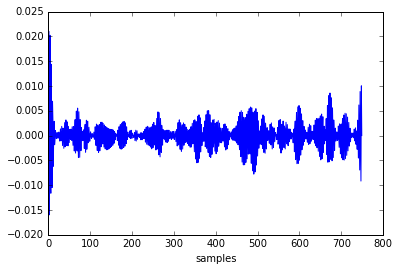

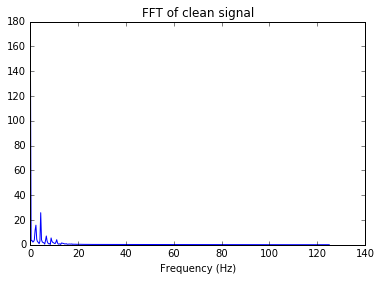

In [264]:
sig, fields=wfdb.rdsamp('sample_data/challenge_training_data/a170s')
print fields['signame']
fs = 250
clean_start = 260
clean_end = 263
channel = 3
clean_duration = clean_end - clean_start

clean_signal = sig[clean_start*fs:clean_end*fs,:]

plt.plot(clean_signal[:,channel],'b-')
plt.xlabel('samples (250 per second)')
plt.show()

filtered_clean_signal = band_pass_filter(clean_signal[:,channel], 70, 90, 50)

# plt.plot(clean_signal[:,channel],'r-')
plt.plot(filtered_clean_signal,'b-')
plt.xlabel('samples')
plt.show()

xf, signal_fft = get_signal_fft(clean_signal, clean_duration, channel)
plot_signal_fft(xf, signal_fft, "FFT of clean signal")